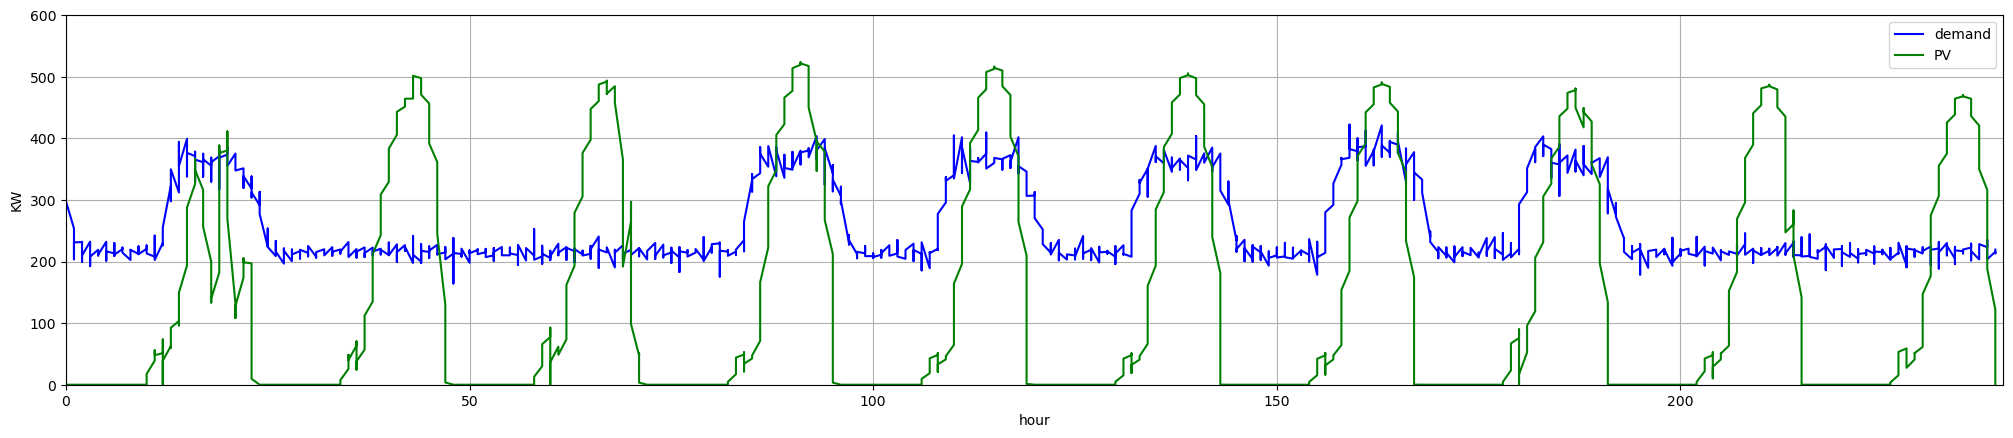

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import math
import pyomo.environ as pyo
from pyomo.opt import SolverFactory 
from pyomo.core import Var
#inport data
s1 = pd.read_csv('1.csv');
#convert datetime to hours
s1['timestamp']=pd.to_datetime(s1['timestamp'])
Initialtime=s1['timestamp'].min()
s1['hours']=(s1['timestamp'] - Initialtime).astype('timedelta64[h]')
# convert power to KW
s1['actual_consumption KW']=(s1['actual_consumption']/250)
s1['actual_pv KW']=(s1['actual_pv']/250)
#plot actual demand and PV generation vs time for period 1 of site 1 
s1_p1=s1[(s1['period_id']==1)]
a=s1_p1['hours']
b=s1_p1['actual_consumption KW']
c=s1_p1['actual_pv KW']
Con=s1_p1['actual_consumption'].values
PV=s1_p1['actual_pv'].values
plt.figure().set_figwidth(25)
plt.xlim(0, 240)
plt.ylim(0, 600)
plt.plot(a,b,color='b',label='demand')
plt.plot(a,c,color='g',label='PV')
plt.xlabel('hour')
plt.ylabel('KW')
plt.legend()
plt.grid()
plt.show()
#plot changing of buy price and sell price vs time for period 1 of site 1
x=s1_p1['hours']
y=s1_p1['price_buy_00']
z=s1_p1['price_sell_00']
plt.figure().set_figwidth(25)
plt.xlim(0, 240)
plt.ylim(0.030, 0.050)
plt.plot(x,y,color='purple',label='buy price')
plt.plot(x,z,color='y',label='sell price')
plt.xlabel('hour')
plt.ylabel('price($KWH)')
plt.legend()
plt.grid()
plt.show()
#import data of battery for site1
s1b = pd.read_csv('metadata.csv')
s1b_1=s1b[(s1b['SiteId']==1)]
q=s1b_1['Battery_1_Capacity']*1000
Q=dict(enumerate(q))#Capacity
p=s1b_1['Battery_1_Power']*1000
P=dict(enumerate(p))#Power
nchar=s1b_1['Battery_1_Charge_Efficiency']
effchar=dict(enumerate(nchar))#efficiency of charging
ndis=s1b_1['Battery_1_Discharge_Efficiency']
effdis=dict(enumerate(ndis))#efficiency of dischargingd

In [2]:
#For net load, is amount of demand minus amount of PV generated 
NetLoad=Con-PV
#Net load has two composition, one is negative, another is positive
pos = np.copy(Con-PV)
neg = np.copy(Con-PV)
for j,e in enumerate(NetLoad):
    if e>=0:
        neg[j]=0
    else:
        pos[j]=0
posDict = dict(enumerate(pos))
negDict = dict(enumerate(neg))
#Set up the pyomo model
m=pyo.ConcreteModel()
#Time is the index of this model
m.T=pyo.RangeSet(0,len(NetLoad)-1)

In [3]:
#Define variables
m.posNL=pyo.Var(m.T,initialize=posDict)#postive net load
m.negNL=pyo.Var(m.T,initialize=negDict)#negative net load
m.SOC=pyo.Var(m.T,bounds=(0,Q[0]),initialize=0)#state of charge
m.posSOC=pyo.Var(m.T,initialize=0)#postive change of state of charge
m.negSOC=pyo.Var(m.T,initialize=0)#negtive change of state of charge
m.PIG=pyo.Var(m.T,bounds=(0,P[0]*(15/60)),initialize=0)#positive input from grid
m.PIV=pyo.Var(m.T,bounds=(0,P[0]*(15/60)),initialize=0)#postive input from PV
m.NOL=pyo.Var(m.T,bounds=(-P[0]*(15/60),0),initialize=0)#negtive output to local
m.NOE=pyo.Var(m.T,bounds=(-P[0]*(15/60),0),initialize=0)#negtive output to sell
#Define Boolean Variables
m.boolC=pyo.Var(m.T,within=pyo.Boolean) #Boolean variable for Charge
m.boolD=pyo.Var(m.T,within=pyo.Boolean,initialize=0)#Boolean variable for discharge 

In [4]:
buy = dict(enumerate(y))
sell = dict(enumerate(z))
#Define parameters
m.s = pyo.Param(m.T, initialize=sell)#Sell price
m.b = pyo.Param(m.T, initialize=buy)#Buy price
m.pl = pyo.Param(m.T, initialize=posDict)#Positive Load
m.nl = pyo.Param(m.T, initialize=negDict)#Negtive Load
m.effchar = pyo.Param(initialize = effchar[0])#Charging efficiency
m.effdis = pyo.Param(initialize = effdis[0])#Discharging efficiency
m.ChargingLimit = pyo.Param(initialize = P[0]*(15/60))#Charging limit
m.DischargingLimit = pyo.Param(initialize = -P[0]*(15/60))#Discharging limit

In [5]:
# define objective function
def Objfun(m):
    return sum((m.b[i]*m.posNL[i]) + (m.s[i]*m.negNL[i]) for i in m.T)  
m.total_cost = pyo.Objective(rule=Objfun,sense=pyo.minimize)

In [6]:
# define the relation between the value of state of charge, positive and negative state of charge
def SOC_rule(m,t):
    if t==0:
        return (m.SOC[t] == m.posSOC[t]+m.negSOC[t])
    else:
        return (m.SOC[t] == m.SOC[t-1]+m.posSOC[t]+m.negSOC[t])   
m.Batt_SOC = pyo.Constraint(m.T,rule=SOC_rule)

In [7]:
 #Use big M method and specify boolean variables to define constrains for changing of state of charge

#Define the rule for postive changing of SOC
def Boolchar1(m,i):
    M=500000
    return((m.posSOC[i])<=M*(1-m.boolD[i]))
m.char1=pyo.Constraint(m.T,rule=Boolchar1)
#Impose a redundant lower limit limit
def Boolchar2(m,i):
    return((m.posSOC[i])>=0)
m.char2=pyo.Constraint(m.T,rule=Boolchar2)
#Define the rule for negative changing of SOC
def BoolDis1(m,i):
    M=500000
    return((m.negSOC[i])>=-M*(m.boolD[i]))
m.Dis1=pyo.Constraint(m.T,rule=BoolDis1)
def BoolDis2(m,i):
    return((m.negSOC[i])<=0)
m.Dis2=pyo.Constraint(m.T,rule=BoolDis2)
#Ensure the battery can't charge and discahrge together
def Char_Dis(m,i):
    return (m.boolD[i]+m.boolC[i],1)
m.CharDis=pyo.Constraint(m.T,rule=Char_Dis)

In [8]:
#For charging efficiency
def posChar_rule(m,i):
    return((m.PIG[i]+m.PIV[i])==m.posSOC[i]/effchar[0])
m.pos_Char=pyo.Constraint(m.T,rule=posChar_rule)
#For discharging efficiency
def disChar_rule(m,i):
    return((m.NOL[i]+m.NOE[i])==m.negSOC[i]*effdis[0])
m.dis_Char=pyo.Constraint(m.T,rule=disChar_rule)


In [9]:
#For Charging limit
def posCharlim_rule(m,i):
    return((m.PIG[i]+m.PIV[i])<=m.ChargingLimit)
m.Char_lim=pyo.Constraint(m.T,rule=posCharlim_rule)
#For discharging limit
def disCharlim_rule(m,i):
    return((m.NOL[i]+m.NOE[i])>=m.DischargingLimit)
m.dis_Char_lim=pyo.Constraint(m.T,rule=disCharlim_rule)

In [10]:
#For ensuring energy avaliable for charging from PV is less or equal to excess PV
def Char_in_PV(m,i):
    return (m.PIV[i]<=-m.nl[i])
m.CharFromPV=pyo.Constraint(m.T,rule=Char_in_PV)
#For ensuring energy using locally must smaller or eqial to demand not met by PV
def disChar_out_Cell(m,i):
    return (m.NOL[i]>=-m.pl[i])
m.UseByLocal=pyo.Constraint(m.T,rule=disChar_out_Cell)

In [11]:
#Define decision varibles
#For postive demand of electricity
def Charge_Rule(m,i):
    return m.posNL[i]==(m.pl[i]+m.PIG[i]+m.NOL[i])
m.PosDemand = pyo.Constraint(m.T,rule=Charge_Rule)
#For negtive demand of electricity
def DisCharge_Rule(m,i):
    return m.negNL[i]==(m.nl[i]+m.PIV[i]+m.NOE[i])
m.NegDemand = pyo.Constraint(m.T,rule=DisCharge_Rule)       

In [12]:
#Solving the Optimization problem
opt = SolverFactory('cplex')


In [13]:
#Get results and shows results are optimal results
results=opt.solve(m)
print(results.solver.termination_condition)

optimal


In [14]:
#Read in value for each of the variables
outputVars=np.zeros((9,len(z)))
j=0
for v in m.component_objects(Var,active=True):
    print(v.getname())
    varobject=getattr(m,str(v))
    for index in varobject:
        outputVars[j,index]=varobject[index].value
    j+=1
    if j>=9:
         break     

posNL
negNL
SOC
posSOC
negSOC
PIG
PIV
NOL
NOE


In [15]:
#Price with the battery
price_with_battery=sum(buy[i]*outputVars[0,i]/1000+ sell[i]*outputVars[1,i]/1000 for i in m.T)
print(price_with_battery)
#Price without the battery
price_without_battery=sum(buy[i]*pos[i]/1000 + sell[i]*neg[i]/1000 for i in m.T)
print(price_without_battery)
difference=price_without_battery-price_with_battery
print(difference)

1160.4121867860695
1235.4716671933984
75.05948040732892


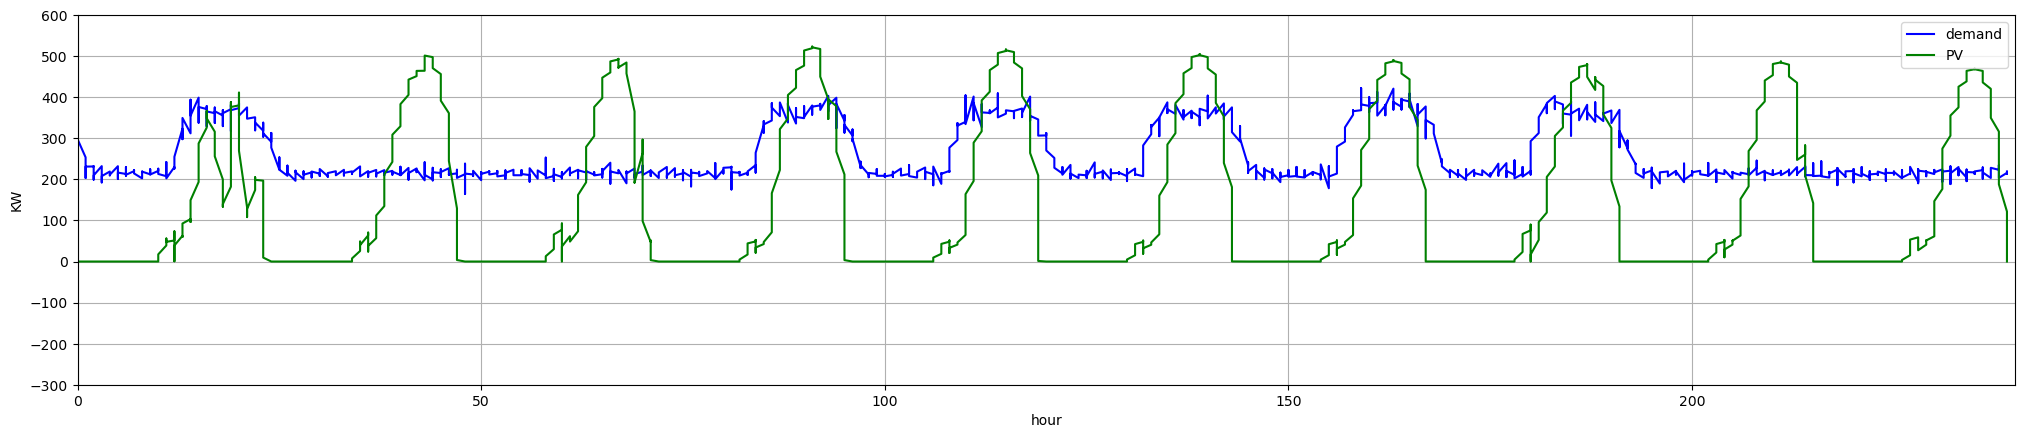

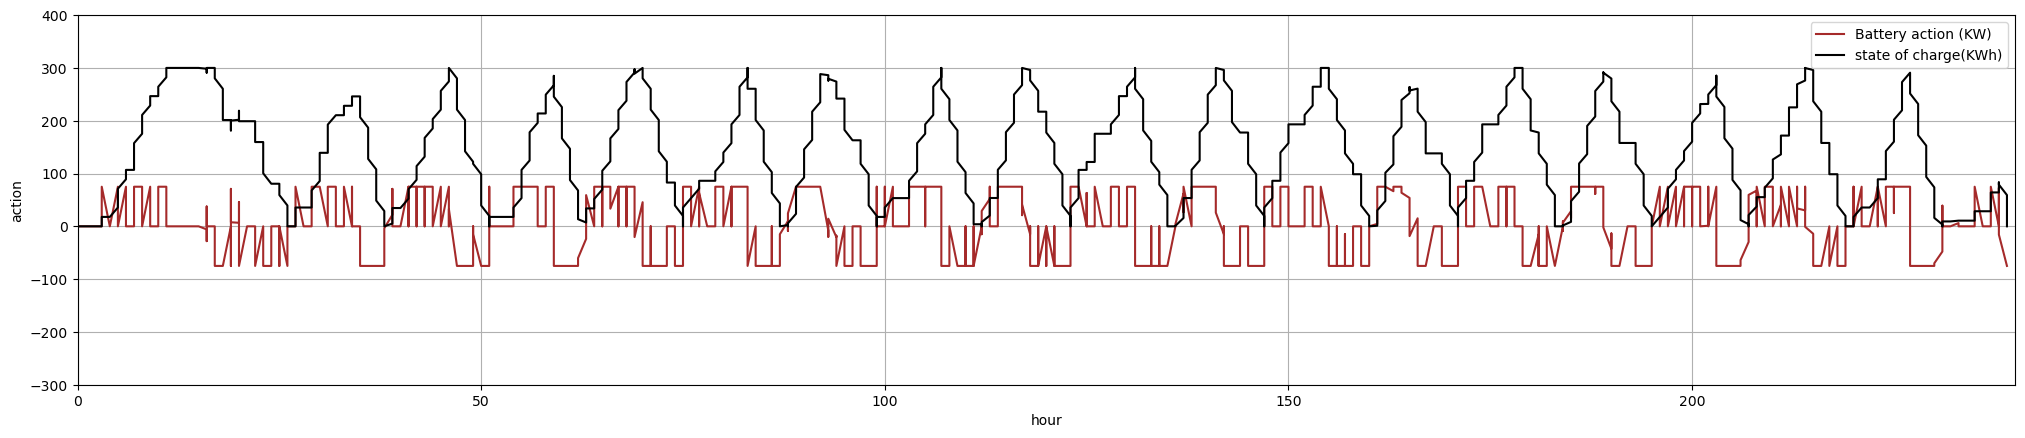

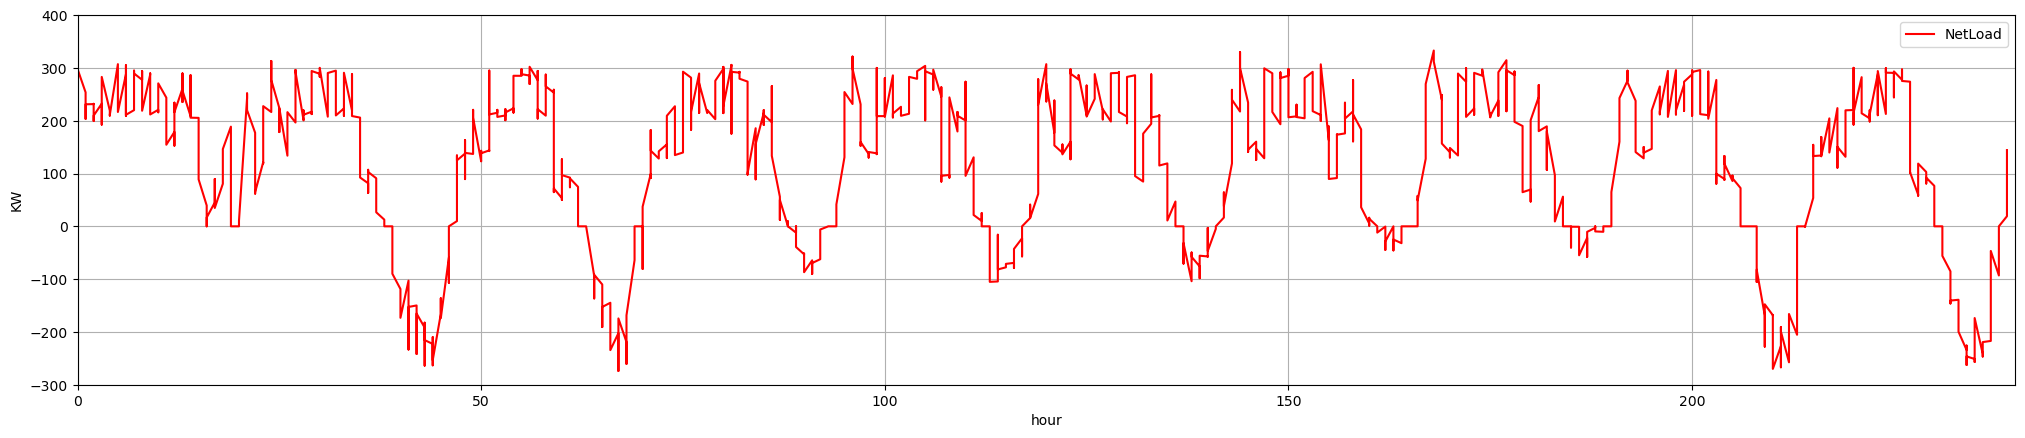

In [16]:
#Plot the result
#Plot the original demand,PV, buy and sell price
#plot actual demand and PV generation vs time for period 1 of site 1 
s1_p1=s1[(s1['period_id']==1)]
a=s1_p1['hours']
b=s1_p1['actual_consumption KW']
c=s1_p1['actual_pv KW']
d=outputVars[0]+outputVars[1]
plt.figure().set_figwidth(25)
plt.xlim(0, 240)
plt.ylim(-300, 600)
plt.plot(a,b,color='b',label='demand')
plt.plot(a,c,color='g',label='PV')
plt.xlabel('hour')
plt.ylabel('KW')
plt.legend()
plt.grid()
plt.show()
#plot changing of buy price and sell price vs time for period 1 of site 1
x=s1_p1['hours']
y=s1_p1['price_buy_00']
z=s1_p1['price_sell_00']
plt.figure().set_figwidth(25)
plt.xlim(0, 240)
plt.ylim(0.030, 0.050)
plt.plot(x,y,color='purple',label='buy price')
plt.plot(x,z,color='y',label='sell price')
plt.xlabel('hour')
plt.ylabel('price($KWH)')
plt.legend()
plt.grid()
plt.show()
#Plot the battery charging and discharging time, and the state of charge over time
plt.figure().set_figwidth(25)
plt.xlim(0, 240)
plt.ylim(-300, 400)
plt.plot(x,sum(outputVars[5:8]/250),color="brown",label='Battery action (KW)')
plt.plot(x,outputVars[2]/1000,color="black",label='state of charge(KWh)')
plt.xlabel('hour')
plt.ylabel('action')
plt.legend()
plt.grid()
plt.show()
#plt.plot(a,sum(outputVars[0:1]/250),color='red')
plt.figure().set_figwidth(25)
plt.xlim(0, 240)
plt.ylim(-300, 400)
plt.plot(a,d/250,color='red',label='NetLoad')
plt.xlabel('hour')
plt.ylabel('KW')
plt.legend()
plt.grid()
plt.show()

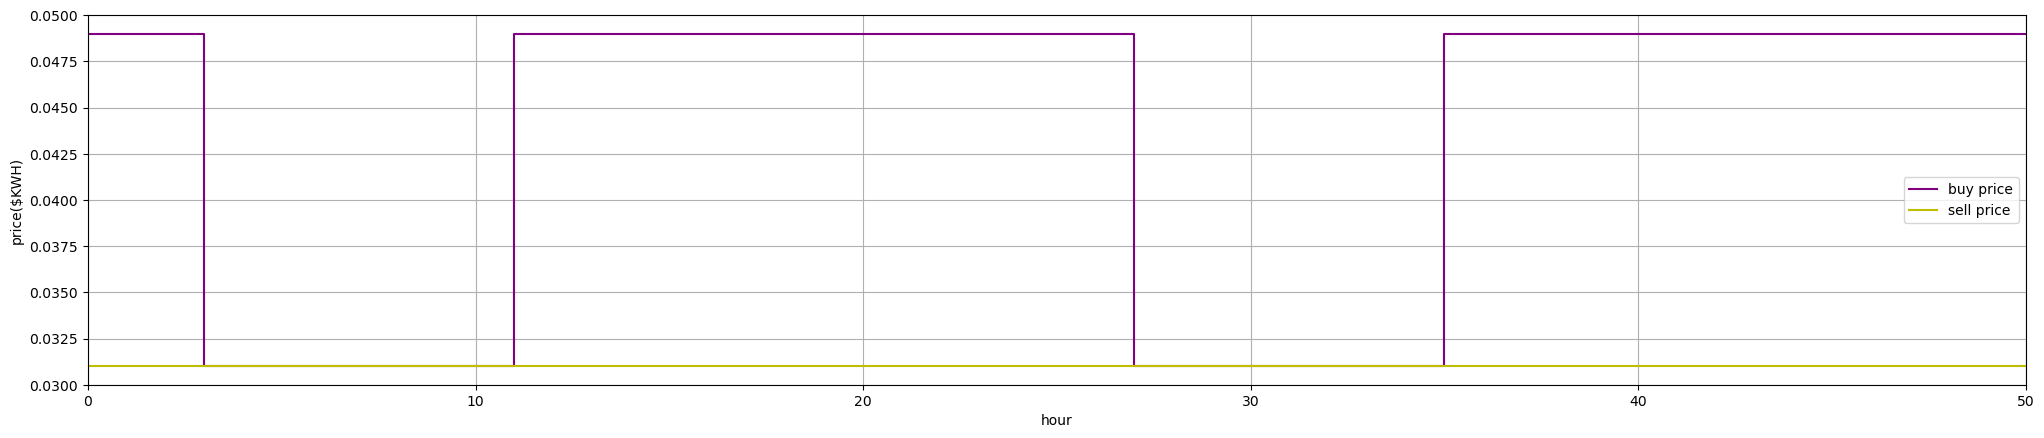

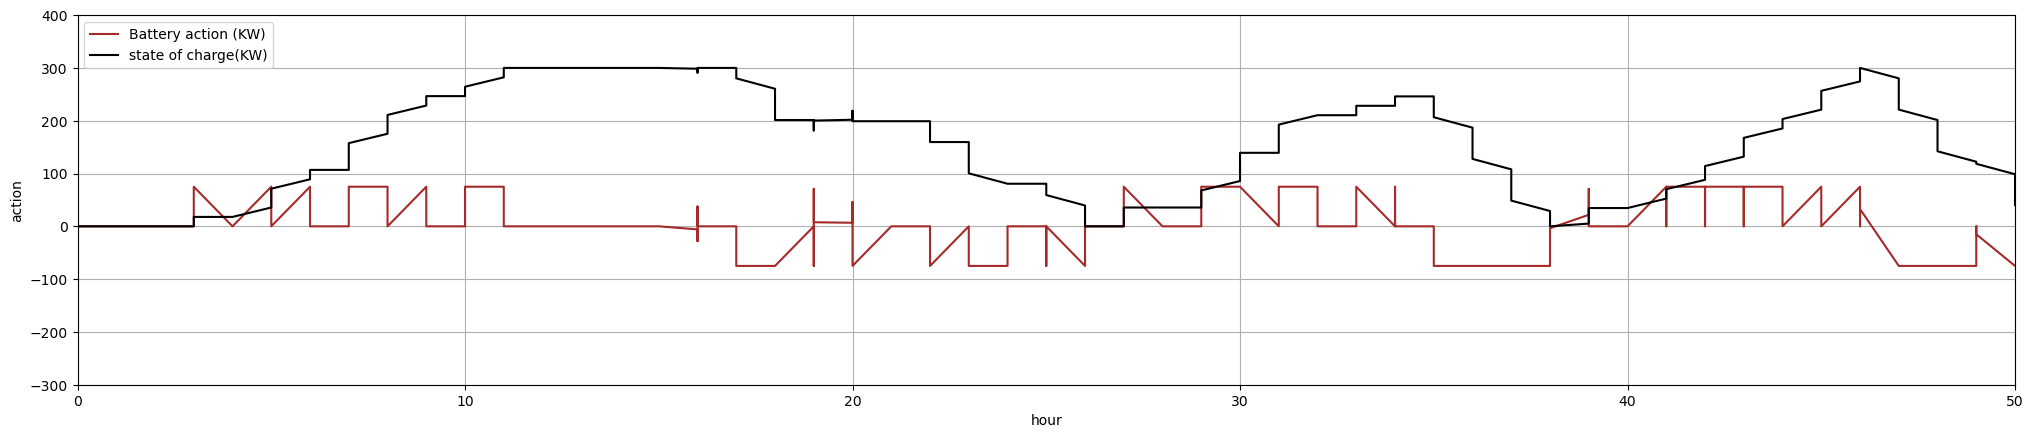

In [17]:
#Plot the result
#Plot the original demand,PV, buy and sell price
#plot actual demand and PV generation vs time for period 1 of site 1 
s1_p1=s1[(s1['period_id']==1)]
a=s1_p1['hours']
b=s1_p1['actual_consumption KW']
c=s1_p1['actual_pv KW']
d=outputVars[0]+outputVars[1]
plt.figure().set_figwidth(25)
plt.xlim(0, 50)
plt.ylim(-300, 600)
plt.plot(a,b,color='b',label='demand')
plt.plot(a,c,color='g',label='PV')
plt.xlabel('hour')
plt.ylabel('KW')
plt.legend()
plt.grid()
plt.show()
#plot changing of buy price and sell price vs time for period 1 of site 1
x=s1_p1['hours']
y=s1_p1['price_buy_00']
z=s1_p1['price_sell_00']
plt.figure().set_figwidth(25)
plt.xlim(0, 50)
plt.ylim(0.030, 0.050)
plt.plot(x,y,color='purple',label='buy price')
plt.plot(x,z,color='y',label='sell price')
plt.xlabel('hour')
plt.ylabel('price($KWH)')
plt.legend()
plt.grid()
plt.show()
#Plot the battery charging and discharging time, and the state of charge over time
plt.figure().set_figwidth(25)
plt.xlim(0, 50)
plt.ylim(-300, 400)
plt.plot(x,sum(outputVars[5:8]/250),color="brown",label='Battery action (KW)')
plt.plot(x,outputVars[2]/1000,color="black",label='state of charge(KW)')
plt.xlabel('hour')
plt.ylabel('action')
plt.legend()
plt.grid()
plt.show()
#plt.plot(a,sum(outputVars[0:1]/250),color='red')
plt.figure().set_figwidth(25)
plt.xlim(0, 50)
plt.ylim(-300, 400)
plt.plot(a,d/250,color='red',label='NetLoad')
plt.xlabel('hour')
plt.ylabel('KW')
plt.legend()
plt.grid()
plt.show()

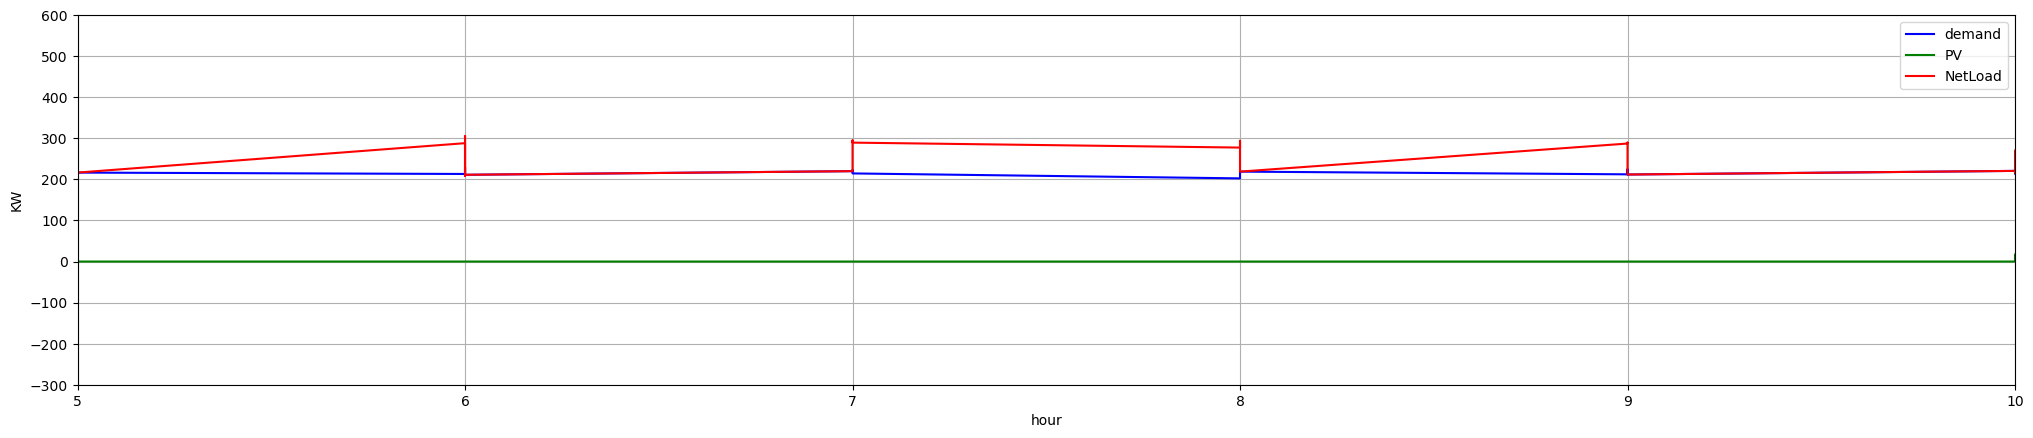

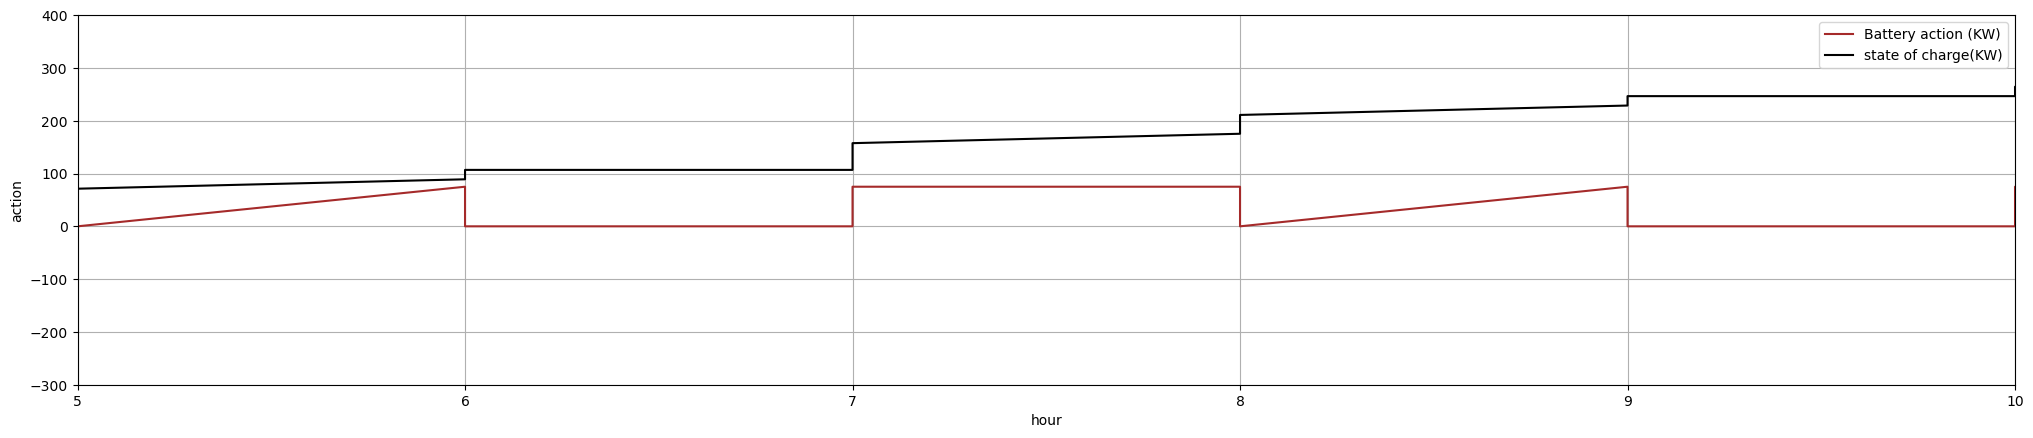

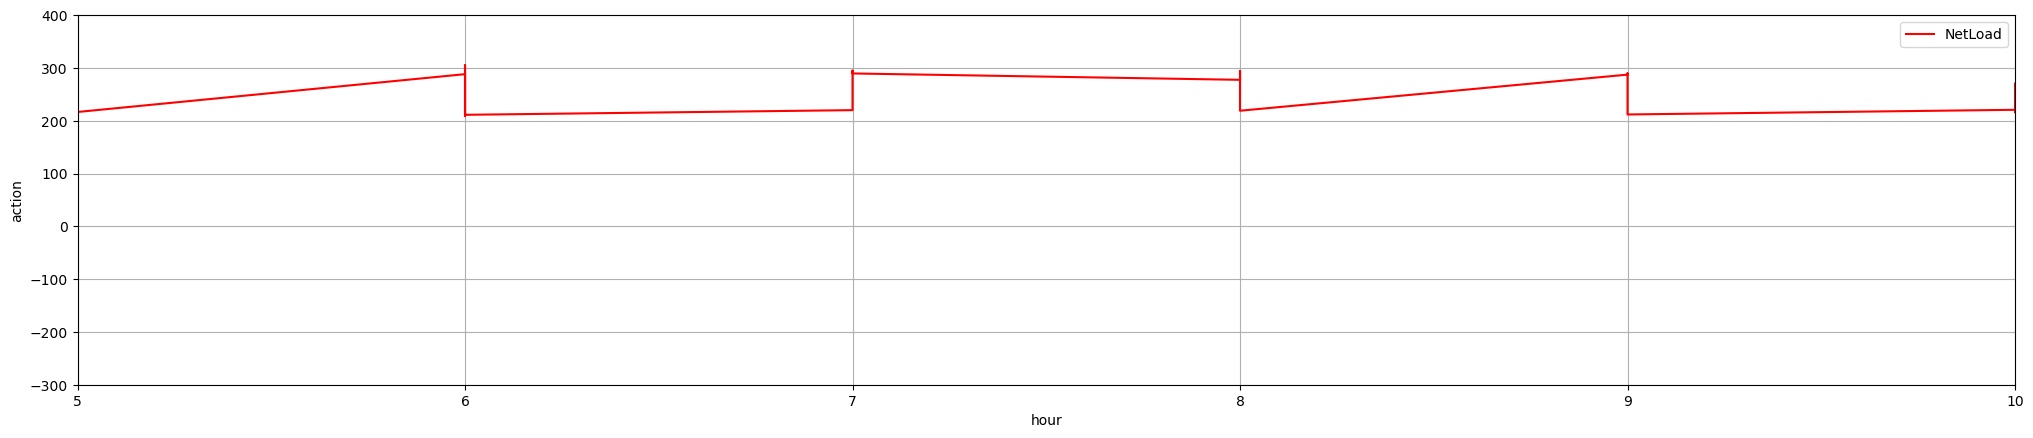

In [18]:
#Plot the result
#Plot the original demand,PV, buy and sell price
#plot actual demand and PV generation vs time for period 1 of site 1 
s1_p1=s1[(s1['period_id']==1)]
a=s1_p1['hours']
b=s1_p1['actual_consumption KW']
c=s1_p1['actual_pv KW']
d=outputVars[0]+outputVars[1]
plt.figure().set_figwidth(25)
plt.xlim(5, 10)
plt.ylim(-300, 600)
plt.plot(a,b,color='b',label='demand')
plt.plot(a,c,color='g',label='PV')
plt.plot(a,d/250,color='red',label='NetLoad')
plt.xlabel('hour')
plt.ylabel('KW')
plt.legend()
plt.grid()
plt.show()
#plot changing of buy price and sell price vs time for period 1 of site 1
x=s1_p1['hours']
y=s1_p1['price_buy_00']
z=s1_p1['price_sell_00']
plt.figure().set_figwidth(25)
plt.xlim(5, 10)
plt.ylim(0.030, 0.050)
plt.plot(x,y,color='purple',label='buy price')
plt.plot(x,z,color='y',label='sell price')
plt.xlabel('hour')
plt.ylabel('price($KWH)')
plt.legend()
plt.grid()
plt.show()
#Plot the battery charging and discharging time, and the state of charge over time
plt.figure().set_figwidth(25)
plt.xlim(5, 10)
plt.ylim(-300, 400)
plt.plot(x,sum(outputVars[5:8]/250),color="brown",label='Battery action (KW)')
plt.plot(x,outputVars[2]/1000,color="black",label='state of charge(KW)')
plt.xlabel('hour')
plt.ylabel('action')
plt.legend()
plt.grid()
plt.show()
#plt.plot(a,sum(outputVars[0:1]/250),color='red')
plt.figure().set_figwidth(25)
plt.xlim(5, 10)
plt.ylim(-300, 400)
plt.plot(a,d/250,color='red',label='NetLoad')
plt.xlabel('hour')
plt.ylabel('action')
plt.legend()
plt.grid()
plt.show()

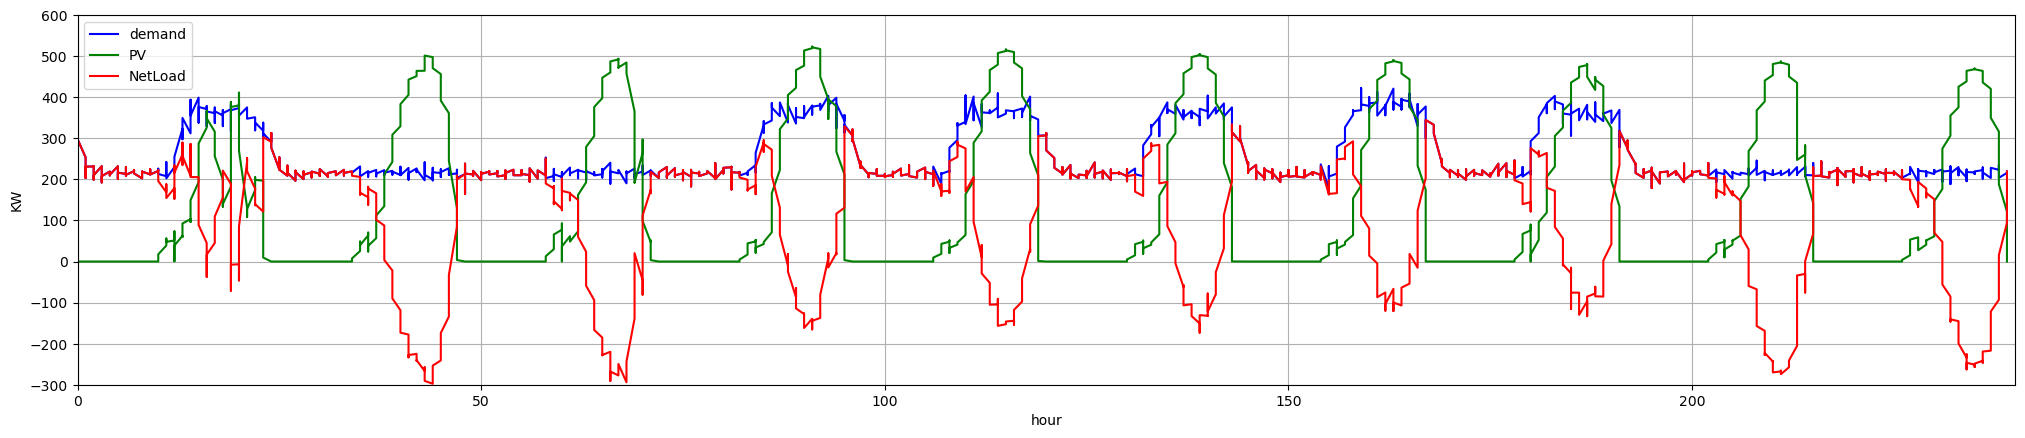

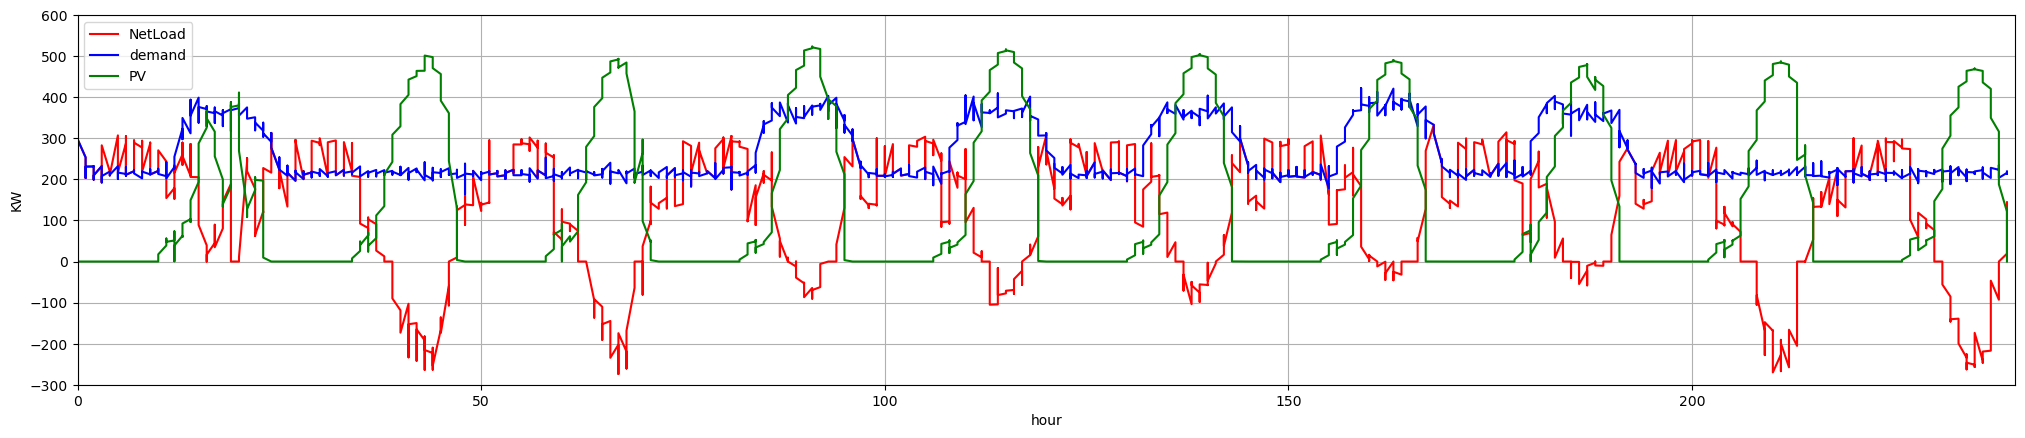

In [19]:
#Case without battery
s1_p1=s1[(s1['period_id']==1)]
a=s1_p1['hours']
b=s1_p1['actual_consumption KW']
c=s1_p1['actual_pv KW']
d=pos+neg
plt.figure().set_figwidth(25)
plt.xlim(0, 240)
plt.ylim(-300, 600)
plt.plot(a,b,color='b',label='demand')
plt.plot(a,c,color='g',label='PV')
plt.plot(a,d/250,color='red',label='NetLoad')
plt.xlabel('hour')
plt.ylabel('KW')
plt.legend()
plt.grid()
plt.show()
#Case with battery
s1_p1=s1[(s1['period_id']==1)]
a=s1_p1['hours']
b=s1_p1['actual_consumption KW']
c=s1_p1['actual_pv KW']
d=outputVars[0]+outputVars[1]
plt.figure().set_figwidth(25)
plt.xlim(0, 240)
plt.ylim(-300, 600)
plt.plot(a,d/250,color='red',label='NetLoad')
plt.plot(a,b,color='b',label='demand')
plt.plot(a,c,color='g',label='PV')
plt.xlabel('hour')
plt.ylabel('KW')
plt.legend()
plt.grid()
plt.show()

In [20]:
#Total pos net load save
saved=(pos)/250-(outputVars[0]/250)
total_saved=sum(saved)
print(total_saved)
print(sum(pos/250))
print(sum(outputVars[0]/250))

8251.434207616061
145123.92669362764
136872.49248601156
